Files already downloaded and verified
Epoch 1, Loss: 9714.4130859375
Epoch 2, Loss: 7918.3974609375
Epoch 3, Loss: 7785.6259765625
Epoch 4, Loss: 8119.29443359375
Epoch 5, Loss: 7211.1474609375
Epoch 6, Loss: 6727.3603515625
Epoch 7, Loss: 6348.306640625
Epoch 8, Loss: 6332.14111328125
Epoch 9, Loss: 6173.8896484375
Epoch 10, Loss: 6344.853515625
Epoch 11, Loss: 6695.97265625
Epoch 12, Loss: 6047.5498046875
Epoch 13, Loss: 6608.60888671875
Epoch 14, Loss: 6533.9736328125
Epoch 15, Loss: 5790.978515625
Epoch 16, Loss: 6076.2587890625
Epoch 17, Loss: 5713.19921875
Epoch 18, Loss: 6456.755859375
Epoch 19, Loss: 6093.06396484375
Epoch 20, Loss: 6356.95947265625


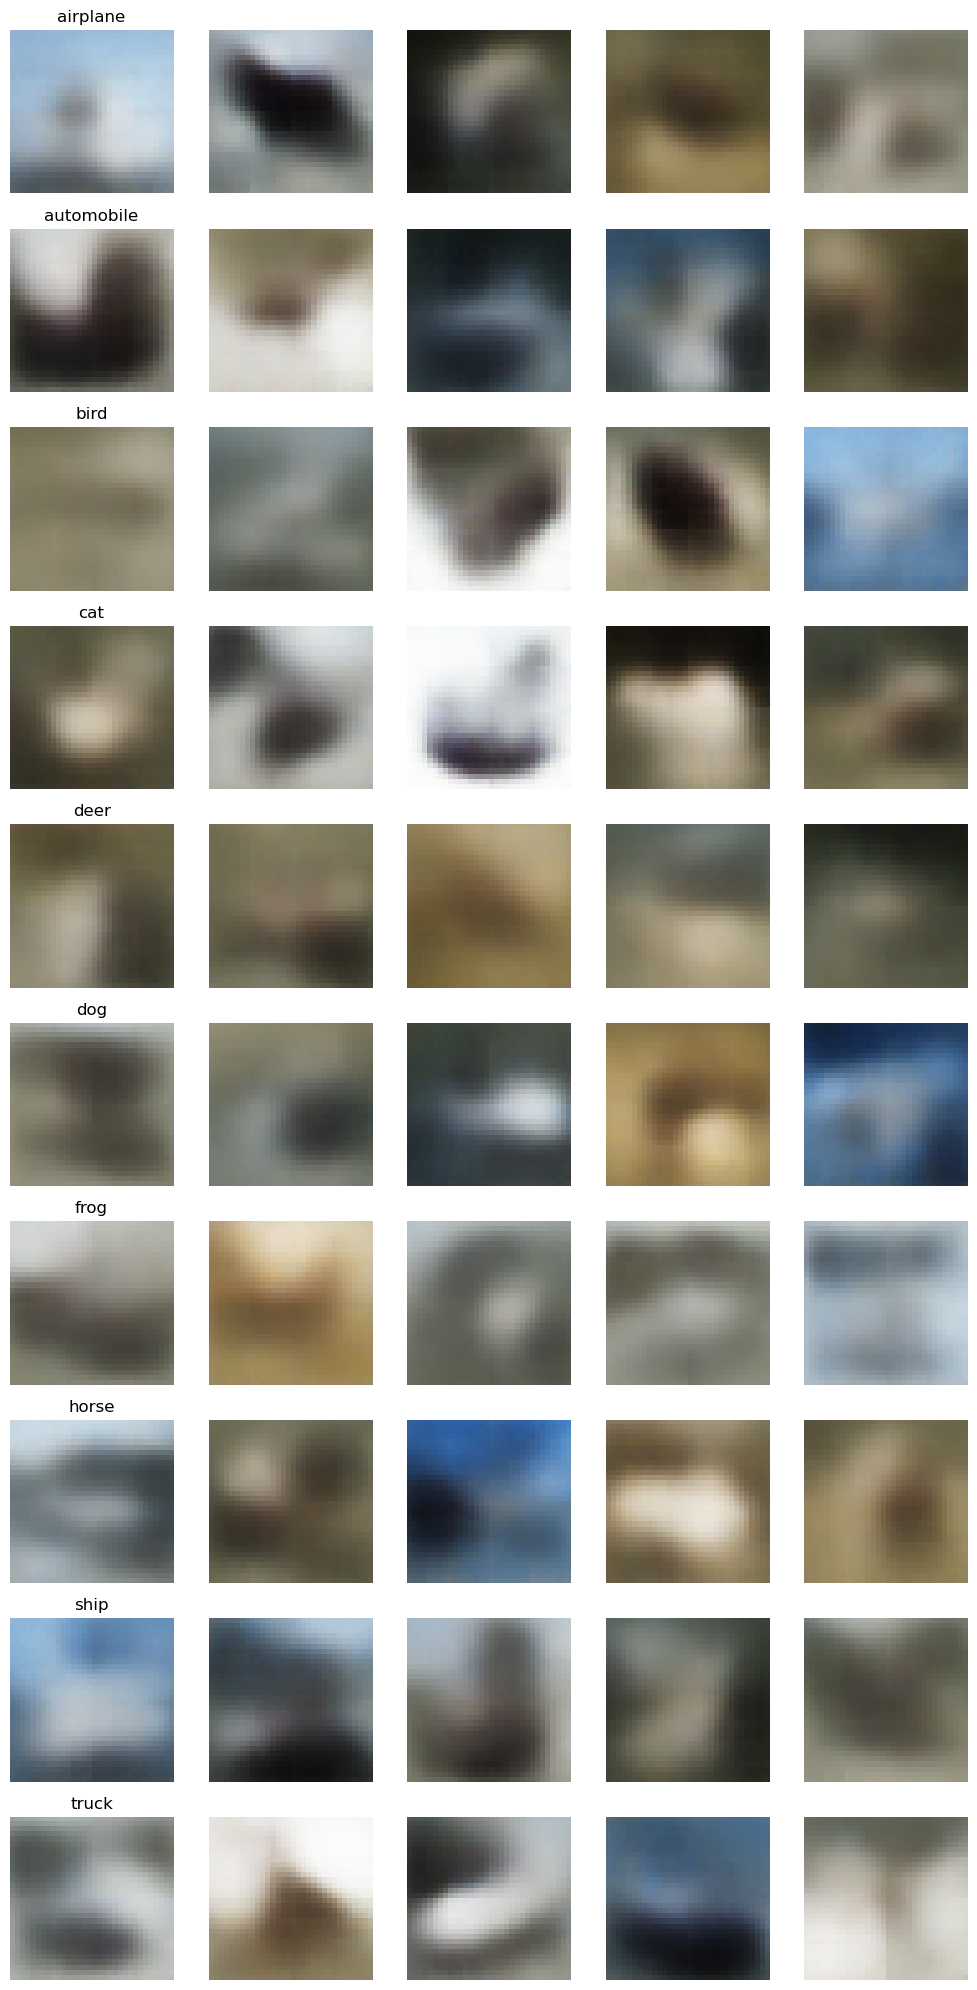

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

PATH = '/content/CVAE/generated_images'
epochs = 20

# 定義CVAE模型
class Encoder(nn.Module):
    def __init__(self, latent_dim, input_size=32):
        super(Encoder, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3, stride=2, padding=1)  # 32 -> 16
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1) # 16 -> 8
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1) # 8 -> 4
        self.conv4 = nn.Conv2d(64, 128, 3, stride=2, padding=1) # 4 -> 2
        self.flatten = nn.Flatten()
        
        final_size = input_size // 2**4  # 32 -> 16 -> 8 -> 4 -> 2
        self.fc1 = nn.Linear(final_size * final_size * 128, 256)
        
        self.fc_mean = nn.Linear(256, latent_dim)
        self.fc_log_var = nn.Linear(256, latent_dim)
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        z_mean = self.fc_mean(x)
        z_log_var = self.fc_log_var(x)
        return z_mean, z_log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_size=32):
        super(Decoder, self).__init__()
        
        final_size = output_size // 2**4  # 32 -> 16 -> 8 -> 4 -> 2
        self.fc1 = nn.Linear(latent_dim, final_size * final_size * 128)
        
        self.conv1 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1) # 2 -> 4
        self.conv2 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)  # 4 -> 8
        self.conv3 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1)  # 8 -> 16
        self.conv4 = nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1)   # 16 -> 32

    def forward(self, z):
        x = torch.relu(self.fc1(z))
        x = x.view(-1, 128, 2, 2)  # 修改這裡以匹配最終特徵圖大小
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.sigmoid(self.conv4(x))
        return x

class CVAE(nn.Module):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        z_mean, z_log_var = self.encoder(x)
        z = self.reparameterize(z_mean, z_log_var)
        x_recon = self.decoder(z)
        return x_recon, z_mean, z_log_var

    def reparameterize(self, mean, log_var):
        epsilon = torch.randn_like(log_var)
        return mean + torch.exp(0.5 * log_var) * epsilon

# 載入CIFAR-10資料集
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# 訓練CVAE模型
latent_dim = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cvae = CVAE(latent_dim).to(device)
optimizer = optim.Adam(cvae.parameters(), lr=1e-3)

def loss_function(x, x_recon, z_mean, z_log_var):
    recon_loss = nn.functional.mse_loss(x_recon, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
    return recon_loss + kl_divergence

# 訓練迴圈
for epoch in range(epochs):
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        x_recon, z_mean, z_log_var = cvae(x)
        loss = loss_function(x, x_recon, z_mean, z_log_var)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# 選擇10個不同類別的圖片索引
indices = []
classes = np.arange(10)
for i in classes:
    idx = np.where(np.array(train_dataset.targets) == i)[0][0]
    indices.append(idx)

# 生成每個類別的 1000 張影像
num_samples_per_class = 1000
generated_images = []

with torch.no_grad():
    for i in classes:
        for _ in range(num_samples_per_class):
            z = torch.randn(1, latent_dim).to(device)
            z[:, i] = torch.randn(1).to(device)
            x_recon = cvae.decoder(z)
            generated_images.append(x_recon.squeeze(0))


# 定義10個類別的顏色
name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 顯示每個類別的前5張圖片
plt.figure(figsize=(20, 20))
for i in range(10):
    for j in range(5):
        idx = i * 1000 + j
        image = generated_images[idx].cpu().numpy().transpose(1, 2, 0)
        plt.subplot(10, 10, i * 10 + j + 1)
        plt.imshow(image)
        plt.axis('off')
        if j == 0:
            plt.title(name[i])
plt.tight_layout()
plt.show()

# 創建一個資料夾來保存生成的圖片
os.makedirs(PATH, exist_ok=True)

# 將生成的圖片保存到硬碟
for i, img in enumerate(generated_images):
    # 將圖片數據轉換為 0-255 範圍
    img = (img * 255).clamp(0, 255).byte()
    img = img.permute(1, 2, 0)  # 將張量的形狀從 (channels, height, width) 改為 (height, width, channels)
    img = Image.fromarray(img.cpu().numpy())
    img.save(f'{PATH}/image_{i}.png')


In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import os
from scipy import linalg
import matplotlib.pyplot as plt
from PIL import Image

PATH = '/content/CVAE/generated_images'
epochs = 20
latent_dim = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定義 CVAE 模型 (略過這部分代碼，假設你已經定義好模型)

# 載入 CIFAR-10 測試集
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# 加載預訓練的 Inception V3 模型
inception_model = models.inception_v3(pretrained=True, transform_input=False).to(device)
inception_model.eval()

# 定義一個函數來提取特徵
def get_features(images, model):
    model.eval()
    features = []
    with torch.no_grad():
        for i in range(0, images.size(0), 128):  # 使用合適的 batch size 進行處理
            batch = images[i:i+128].to(device)
            batch = nn.functional.interpolate(batch, size=(299, 299), mode='bilinear', align_corners=False)
            feature = model(batch).detach().cpu().numpy()
            features.append(feature)
    features = np.concatenate(features, axis=0)
    return features

# 提取生成圖片的特徵
gen_images = torch.stack(generated_images)  # 保證生成圖片是四維的 (N, 3, 32, 32)
gen_features = get_features(gen_images, inception_model)

# 提取真實圖片的特徵
real_images = []
for x, _ in test_loader:
    real_images.append(x)
real_images = torch.cat(real_images, dim=0)  # 保證真實圖片是四維的 (N, 3, 32, 32)
real_features = get_features(real_images, inception_model)

# 計算 FID
def calculate_fid(real_features, gen_features):
    mu1 = np.mean(real_features, axis=0)
    mu2 = np.mean(gen_features, axis=0)
    sigma1 = np.cov(real_features, rowvar=False)
    sigma2 = np.cov(gen_features, rowvar=False)

    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

fid_score = calculate_fid(real_features, gen_features)
print(f"FID score: {fid_score}")


Files already downloaded and verified


c:\Users\benny\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\benny\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FID score: 1176.063994892439
